<a href="https://colab.research.google.com/github/RVijayChiranjithReddy/Autolabel_encoder/blob/main/ALE_WCycleGAN_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons

In [ ]:

from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.initializers import RandomNormal
from keras.applications import *
import tensorflow as tf
from keras.models import Sequential,Model
import matplotlib.pyplot as plt
import keras.backend as K
from keras.optimizers import RMSprop, SGD, Adam
import cv2
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle
import tensorflow_addons as tfa
%matplotlib inline
K.set_learning_phase(1)


/usr/local/lib/python3.7/dist-packages/keras/backend.py:400: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
df = pandas.read_csv('/content/styles.csv')
df.fillna('DK', inplace = True) 
data = {}
for i in range(44446):
  tags = [str(x) for x in df.loc[i].values[1:9] if type(x) is str]
  #desc = df.loc[i].values[9]
  #if type(desc) is not float:
    #for de in desc.split():
     #if de.isalpha() and de not in tags:
        #tags.append(de)
  data[str(df.loc[i].values[0])] = ':'.join(tags)
vocab = []
for k,v in data.items():
  temp = list(set(v.split(':')))
  vocab = vocab + temp
  vocab = list(set(vocab))
print(len(vocab))
#from tensorflow.keras.preprocessing.text import one_hot
#for k,d in data.items():
  #data_encoded[k] = one_hot(' '.join(d),len(vocab))
tokenizer = Tokenizer(num_words=len(vocab))

# This builds the word index
tokenizer.fit_on_texts(data.values())


# This turns strings into lists of integer indices.
train_sequences = tokenizer.texts_to_sequences(data.values())
print(tokenizer.word_index)

240
{'casual': 1, 'men': 2, 'apparel': 3, 'summer': 4, 'women': 5, 'topwear': 6, 'shoes': 7, 'accessories': 8, 'fall': 9, 'black': 10, 'footwear': 11, 'winter': 12, 'tshirts': 13, 'blue': 14, 'sports': 15, 'white': 16, 'watches': 17, 'brown': 18, 'shirts': 19, 'ethnic': 20, 'bags': 21, 'formal': 22, 'spring': 23, 'grey': 24, 'bottomwear': 25, 'care': 26, 'red': 27, 'personal': 28, 'unisex': 29, 'green': 30, 'innerwear': 31, 'wallets': 32, 'pink': 33, 'kurtas': 34, 'flip': 35, 'flops': 36, 'navy': 37, 'tops': 38, 'handbags': 39, 'purple': 40, 'belts': 41, 'and': 42, 'socks': 43, 'heels': 44, 'jewellery': 45, 'silver': 46, 'eyewear': 47, 'sunglasses': 48, 'fragrance': 49, 'sandals': 50, 'sandal': 51, 'briefs': 52, 'boys': 53, 'yellow': 54, 'beige': 55, 'backpacks': 56, 'girls': 57, 'body': 58, 'gold': 59, 'perfume': 60, 'mist': 61, 'jeans': 62, 'shorts': 63, 'maroon': 64, 'trousers': 65, 'orange': 66, 'lips': 67, 'ties': 68, 'flats': 69, 'dress': 70, 'bra': 71, 'loungewear': 72, 'nightwe

In [ ]:
da = {}
ds = {}
i=0
a = tokenizer.sequences_to_matrix(train_sequences,mode='binary')
print(a.shape)
for k,v in data.items():
  da[str(k)] = list(set(train_sequences[i]))
  i=i+1
i=0
for k,v in data.items():
  ds[k] = np.array(a[i,:])
  i=i+1
print(da['10000'])
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy
max_length = 12
d_enc_padded = {}
for k,d in da.items():
 pad = pad_sequences([d],maxlen=max_length,padding='post')
 d_enc_padded[str(k)] = numpy.array(pad[0])
print(d_enc_padded['10000'])

(44446, 240)
[128, 1, 3, 4, 5, 16, 25]
[128   1   3   4   5  16  25   0   0   0   0   0]


In [ ]:
print(max([len(i) for i in da.values()]))


12


In [ ]:
def read_image(fn):
  im = cv2.imread(fn)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
  im = cv2.resize(im, (128,128), interpolation=cv2.INTER_CUBIC)
  im = np.array(im)/127.5-1
  return im

In [ ]:
traini = glob.glob(r'/content/drive/MyDrive/images/*')
print(len(traini))
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        ltn=[]
        se = []
        for j in range(i,i+size):
          if '(' in data[j].split('/')[-1].split('.')[0]:
            ltn.append(d_enc_padded[data[j].split('/')[-1].split('.')[0].split(' ')[0]])
          else:
            ltn.append(d_enc_padded[data[j].split('/')[-1].split('.')[0]])
        i+=size
        tmpsize = yield epoch, np.float32(rtn), np.float32(np.array(ltn)/254)

def minibatchAB(dataA, batchsize):
    batchA = minibatch(dataA, batchsize)
    tmpsize = None    
    while True:        
        ep1, A,B = batchA.send(tmpsize)
        tmpsize = yield ep1, A,B
train_batch = minibatchAB(traini, 1)


44462


In [ ]:
class ClipConstraint(tf.keras.constraints.Constraint):
  def __init__(self, clip_value):
    self.clip_value = clip_value
  def __call__(self, weights):
    return backend.clip(weights, -self.clip_value, self.clip_value)
  def get_config(self):
    return {'clip_value': self.clip_value}

In [ ]:
const = ClipConstraint(0.01)

In [ ]:
class CycleGAN():
  def __init__(self,train_batch,const):
    self.img_rows = 128 
    self.img_cols = 128 
    self.channels = 3 
    self.dloss = []
    self.gloss = []
    self.iter = []
    self.traindata = train_batch
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.label_shape = (12,)
    self.lambda_cycle = 10
    optimizer = Adam(learning_rate = 0.002)
    self.const = const
    self.g_AB = self.build_label_generator() 
    self.g_BA = self.build_img_generator()
    A = Input(shape=self.img_shape) 
    B = Input(shape=self.label_shape) 
    fake_B = self.g_AB(A) 
    fake_A = self.g_BA(B)
    reconstr_A = self.g_BA(fake_B) 
    reconstr_B = self.g_AB(fake_A)
    self.d_A = self.build_img_label_discriminator() 
    self.d_B = self.build_img_label_discriminator() 
    self.d_A.compile(loss=self.wa_loss,optimizer=RMSprop(0.00005)) 
    self.d_B.compile(loss=self.wa_loss,optimizer=RMSprop(0.00005))  
    self.d_A.trainable = False 
    self.d_B.trainable = False
    valid_A = self.d_A([fake_A,B]) 
    valid_B = self.d_B([A,fake_B])
    self.classifier = Model(inputs = A,outputs = fake_B)
    self.classifier.compile(loss = tf.keras.losses.binary_crossentropy,optimizer = optimizer)
    self.combined = Model(inputs=[A,B],outputs=[valid_A, valid_B,reconstr_A, reconstr_B]) 
    self.combined.compile(loss=[self.wa_loss,self.wa_loss,tf.keras.losses.binary_crossentropy,tf.keras.losses.binary_crossentropy],loss_weights=[1, 1,self.lambda_cycle, self.lambda_cycle],optimizer=RMSprop(0.00005))
  def wa_loss(self,y_true, y_pred):
    return K.mean(y_true * y_pred)
  def build_img_generator(self):
    d0 = Input(shape=self.label_shape)
    d1 = Dense(128,activation = 'relu')(d0)
    d2 = tf.keras.layers.Reshape((1,1,128))(d1)
    d3 = Conv2DTranspose(128,kernel_size = 3,strides = 2,padding = 'same')(d2)
    #d3 = BatchNormalization()(d3)
    d3 = tfa.layers.InstanceNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)
    d3 = Conv2DTranspose(128,kernel_size = 3,strides = 1,padding = 'same')(d3)
    d3 = tfa.layers.InstanceNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)
    d3 = Conv2DTranspose(128,kernel_size = 3,strides = 1,padding = 'same')(d3)
    d3 = tfa.layers.InstanceNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)
    d3 = Conv2DTranspose(64,kernel_size = 3,strides = 2,padding = 'same')(d3)
    d3 = tfa.layers.InstanceNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)
    d3 = Conv2DTranspose(64,kernel_size = 3,strides = 1,padding = 'same')(d3)
    d3 = tfa.layers.InstanceNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)
    d3 = Conv2DTranspose(64,kernel_size = 3,strides = 2,padding = 'same')(d3)
    d3 = tfa.layers.InstanceNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)
    d3 = Conv2DTranspose(64,kernel_size = 3,strides = 1,padding = 'same')(d3)
    d3 = tfa.layers.InstanceNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)
    d3 = Conv2DTranspose(32,kernel_size = 3,strides = 2,padding = 'same')(d3)
    d3 = Conv2DTranspose(32,kernel_size = 3,strides = 1,padding = 'same')(d3)
    d3 = Conv2DTranspose(32,kernel_size = 3,strides = 2,padding = 'same')(d3)
    d3 = tfa.layers.InstanceNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)
    d3 = Conv2DTranspose(16,kernel_size = 3,strides = 2,padding = 'same')(d3)
    d3 = tfa.layers.InstanceNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)
    d3 = Conv2DTranspose(16,kernel_size = 3,strides = 2,padding = 'same')(d3)
    d3 = tfa.layers.InstanceNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)
    d3 = Conv2DTranspose(8,kernel_size = 3,strides = 1,padding = 'same')(d3)
    output_img = Conv2D(3,kernel_size = 3,strides = 1,padding = 'same',activation='tanh')(d3)
    return Model(d0, output_img) 
  def build_label_generator(self):
    d0 = Input(shape=self.img_shape)
    d1 = Conv2D(32,kernel_size = 3,strides = 1,padding = 'same')(d0)
    #d1 = BatchNormalization()(d1)
    d1 = tfa.layers.InstanceNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Conv2D(32,kernel_size = 3,strides = 2,padding = 'same')(d1)
    d1 = tfa.layers.InstanceNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Conv2D(64,kernel_size = 3,strides = 2,padding = 'same')(d1)
    d1 = tfa.layers.InstanceNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Conv2D(64,kernel_size = 3,strides = 1,padding = 'same')(d1)
    d1 = tfa.layers.InstanceNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Conv2D(64,kernel_size = 3,strides = 2,padding = 'same')(d1)
    d1 = tfa.layers.InstanceNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Conv2D(128,kernel_size = 3,strides = 2,padding = 'same')(d1)
    d1 = tfa.layers.InstanceNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Conv2D(128,kernel_size = 3,strides = 1,padding = 'same')(d1)
    d1 = tfa.layers.InstanceNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Conv2D(128,kernel_size = 3,strides = 2,padding = 'same')(d1)
    d1 = tfa.layers.InstanceNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Conv2D(256,kernel_size = 3,strides = 2,padding = 'same')(d1)
    d1 = tfa.layers.InstanceNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Conv2D(512,kernel_size = 3,strides = 2,padding = 'same')(d1)
    d2 = Flatten()(d1)
    d2 = Dense(512,activation = 'relu')(d2)
    d2 = Dense(128,activation='relu')(d2)
    d2 = Dense(32,activation='relu')(d2)
    output_label = Dense(12,activation='sigmoid')(d2)
    return Model(d0, output_label)
  def build_img_label_discriminator(self):
    x1 = Input(shape=self.img_shape)
    x2 = Input(shape=self.label_shape)
    d1 = Conv2D(32,kernel_size = 3,strides = 4,kernel_constraint=self.const, padding = 'same')(x1)
    d1 = tfa.layers.InstanceNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Conv2D(64,kernel_size = 3,strides = 4,kernel_constraint=self.const,padding = 'same')(d1)
    d1 = tfa.layers.InstanceNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Conv2D(128,kernel_size = 3,strides = 2,kernel_constraint=self.const,padding = 'same')(d1)
    d1 = tfa.layers.InstanceNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Conv2D(128,kernel_size = 3,strides = 2,kernel_constraint=self.const,padding = 'same')(d1)
    d1 = tfa.layers.InstanceNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Conv2D(512,kernel_size = 3,strides = 2,kernel_constraint=self.const,padding = 'same')(d1)
    d1 = tfa.layers.InstanceNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d2 = Flatten()(d1)
    d4 = Dense(512)(x2)
    d3 = concatenate([d4,d2])
    d3 = LeakyReLU(0.2)(d3)
    d3 = Dense(64)(d3)
    d3 = LeakyReLU(0.2)(d3)
    d3 = Dense(32)(d3)
    d3 = LeakyReLU(0.2)(d3)
    validity = Dense(1)(d3)
    return Model(inputs = [x1,x2], outputs = [validity])
  def train(self, epochs, batch_size=64, sample_interval=50):
    valid = -np.ones((batch_size,1))
    fake = np.ones((batch_size,1))
    for epoch in range(epochs):
      for i in range(5):
        ep, A,B= next(self.traindata)
        fake_A = self.g_BA.predict(B)
        dA_loss_real = self.d_A.train_on_batch([A,B], valid) 
        dA_loss_fake = self.d_A.train_on_batch([fake_A,B], fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)
        fake_B = self.g_AB.predict(A)
        dB_loss_real = self.d_B.train_on_batch([A,B], valid)
        dB_loss_fake = self.d_B.train_on_batch([A,fake_B], fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)
        classifier_loss = self.classifier.train_on_batch(A,B)
      d_loss = 0.5 * np.add(dA_loss, dB_loss)

      ep, A,B= next(self.traindata)
      g_loss = self.combined.train_on_batch([A,B],[valid, valid, A, B])
      if epoch % sample_interval == 0: 
        self.dloss.append(np.mean(d_loss))
        self.gloss.append(np.mean(g_loss))
        self.iter.append(epoch)
        print("%d [D loss : %f ] [G loss : %f]"%(epoch,np.mean(d_loss),np.mean(g_loss)))
        res = gan.g_AB.predict(np.array([A[0]]))
        print(B[0]*254)
        print(np.floor(res[0]*254))
        #print(np.round(res[0]))


In [ ]:
gan = CycleGAN(train_batch,const)


In [ ]:
gan.train(epochs=1500, batch_size=1, sample_interval=10)

0 [D loss : 0.018471 ] [G loss : 9.567918]
[ 1.  5.  8.  9. 45. 77. 46.  0.  0.  0.  0.  0.]
[10. 20.  6.  4. 52.  4.  0. 20. 94.  1.  2.  1.]
10 [D loss : -0.003003 ] [G loss : 6.752915]
[ 1.  4.  8. 10. 21. 56. 29.  0.  0.  0.  0.  0.]
[ 0. 10.  8.  1.  9.  6.  8.  0.  4.  0.  1.  0.]
20 [D loss : -0.001789 ] [G loss : 7.228310]
[ 1.  5.  8. 10. 12. 21. 95.  0.  0.  0.  0.  0.]
[ 0.  3.  8.  3. 15. 12. 19.  5.  4.  3.  0.  0.]
30 [D loss : 0.004223 ] [G loss : 5.368173]
[ 1.  2.  3.  6. 10. 13. 23.  0.  0.  0.  0.  0.]
[ 5.  3. 10.  9.  9. 37. 57.  1.  0.  0.  0.  0.]
40 [D loss : -0.000666 ] [G loss : 5.064469]
[ 1.  5.  8.  9. 45. 77. 46.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  1. 12. 20. 23.  0.  0.  0.  0.  0.]
50 [D loss : -0.004209 ] [G loss : 7.888131]
[  1.   3.   5.   9.  16. 113.  25.   0.   0.   0.   0.   0.]
[16.  6.  4. 34. 69. 55. 32. 32. 43.  7.  0.  0.]
60 [D loss : -0.022258 ] [G loss : 7.943887]
[32.  1.  4.  5.  8. 27.  0.  0.  0.  0.  0.  0.]
[ 4.  7.  6. 13. 15. 34. 3

In [ ]:
A = read_image('/content/drive/MyDrive/images/40000.jpg')
A = np.expand_dims(A,axis=0)
res = gan.g_AB.predict(A)
print(d_enc_padded['40000'])
print(np.round(res[0]*254))

[ 1  2  8 10 12 47 48  0  0  0  0  0]
[21. 10. 14. 22. 20. 43. 17.  4.  2.  0.  0.  0.]


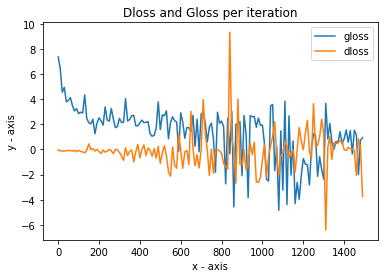

In [ ]:
import matplotlib.pyplot as plt
x1 = gan.iter
y1 = gan.gloss
# plotting the line 1 points 
plt.plot(x1, y1, label = "gloss")
  
# line 2 points
x2 = gan.iter
y2 = gan.dloss
# plotting the line 2 points 
plt.plot(x2, y2, label = "dloss")
  
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Dloss and Gloss per iteration')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

In [ ]:
g_AB = tf.keras.models.load_model('/content/drive/MyDrive/cwgabgan.h5')
